## random forest regression model for predicting price

In [299]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [300]:
X = pd.read_json('../data/model_data/X.json')
y = pd.read_json('../data/model_data/y.json', typ='series')

## some data cleaning

In [301]:
# one-hot-encode categorical features
X_encoded = pd.get_dummies(X.select_dtypes(exclude=np.number))
X_encoded
X_float = X.select_dtypes(include=np.number)
X = pd.concat([X_float, X_encoded], axis=1)
col = X.columns.to_numpy()

In [302]:
# impute np.nan values with numerical sentinel 
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = -999)
X = imp.fit_transform(X)

In [303]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=4)

In [304]:
# oops -- impute the few 0 values by mean imputation
y_test[y_test == 0] = np.mean(y_test)

## hyperparameter selection

In [305]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [306]:
def calc_metrics(y_true, y_pred):
    price_pred = np.exp(y_pred)
    price_true = np.exp(y_true).to_numpy()
    
    mape = mean_absolute_percentage_error(price_true, price_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse_price = mean_squared_error(price_true, price_pred, squared=False)
    
    return mape, mse, rmse_price

In [307]:
# random search for hyperparameter selection
m_list, n_list = [], []
for i in range(100):
        m_list.append(random.randint(1, 50))
        n_list.append(random.randint(1, 20))

m_list.sort()

values = list(zip(m_list, n_list))

In [10]:
# 5-fold cross-validation 
cv_scores = []
for m_, n_ in tqdm(values):
    rf = RandomForestRegressor(max_features=m_, n_estimators=n_, random_state=42, criterion='mse')
    scores = -cross_val_score(rf, X_tr, y_tr, scoring='neg_mean_squared_error') # default: k=5
    cv_scores.append(scores.mean())
    
m, n = values[np.argmin(cv_scores)]
print('optimal values:', (m, n))
print('performance:', np.min(cv_scores))

# best: (21, 18); ~0.0604


optimal values: (6, 19)
performance: 0.06046855558315495


In [308]:
# evaluate on test data
rf = RandomForestRegressor(max_features=21, n_estimators=18, random_state=42)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_test)

## metrics and error visualization

In [310]:
mape, rmsle, rmse = calc_metrics(y_test, y_pred)

print('MAPE:', str(mape) + '%')
print('MSE:', str(rmsle))
print('RMSE (price):', rmse)

MAPE: 8.931503578938953%
MSE: 0.0486222402143564
RMSE (price): 423.54027980496545


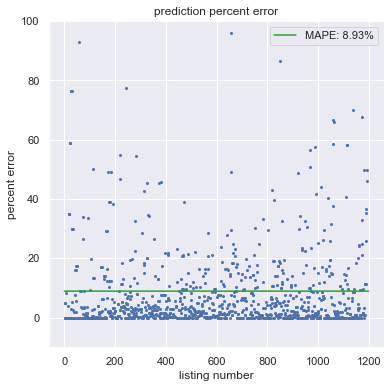

In [313]:
# visualize errors
import matplotlib.pyplot as plt
import seaborn as sns

price_pred = np.exp(y_pred)
price_true = np.exp(y_test.to_numpy())

idx = np.argsort(price_true)
price_true = price_true[idx]
price_pred = price_pred[idx]

sns.set(style='darkgrid')
plt.subplots(figsize=(6,6))
plt.plot(np.abs(price_pred - price_true) / price_true * 100, 'o', markersize=2)
plt.plot(np.arange(1200), [mape] * 1200, label=f'MAPE: {round(mape, 2)}%', color='#2ca02c')
plt.title('prediction percent error')
plt.ylim(-10, 100) # note: some outliers are not visible
plt.ylabel('percent error')
plt.xlabel('listing number')
plt.legend()
plt.savefig('error.png', dpi=300)

## permutation importance

look at these links here:
[explanation](https://scikit-learn.org/stable/modules/permutation_importance.html),
[implementation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)

In [314]:
# let's take the top 10 features!
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='neg_mean_squared_error')
sorted_idx = result.importances_mean.argsort()[:-11:-1]

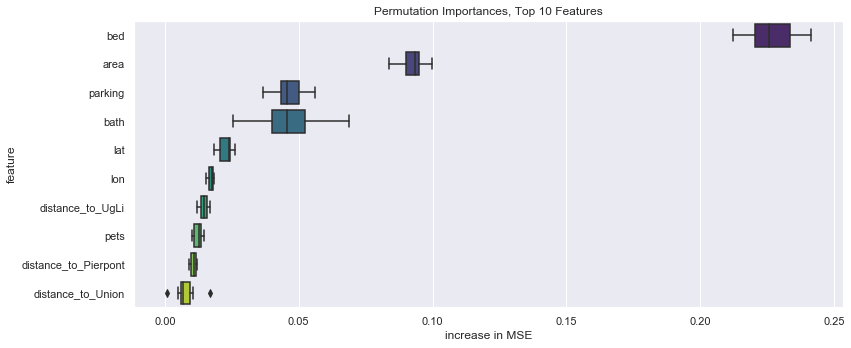

In [315]:
tmp = []
for r, c in zip(result.importances[sorted_idx], col[sorted_idx]):
    for num in r:
        tmp.append((num, c))
    
df_plot = pd.DataFrame(tmp, columns=['increase in MSE', 'feature'])

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x=df_plot['increase in MSE'], y=df_plot['feature'], palette='viridis')
ax.set_title("Permutation Importances, Top 10 Features")
fig.tight_layout()
plt.savefig('permutation-importance-10.png', dpi=300)

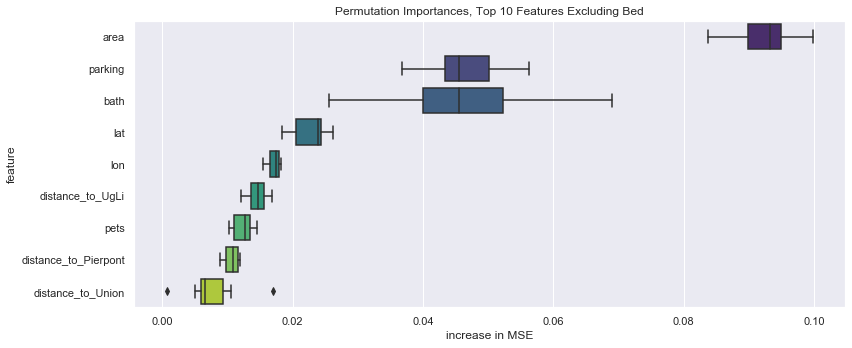

In [316]:
tmp = []
for r, c in zip(result.importances[sorted_idx], col[sorted_idx]):
    for num in r:
        if c != 'bed':
            tmp.append((num, c))
    
df_plot = pd.DataFrame(tmp, columns=['increase in MSE', 'feature'])

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x=df_plot['increase in MSE'], y=df_plot['feature'], palette='viridis')
ax.set_title("Permutation Importances, Top 10 Features Excluding Bed")
fig.tight_layout()
plt.savefig('permutation-importance-9.png', dpi=300)